# Tarea 6 ~ Stauber Daniela
##  1D elliptic self adjoint eigenvalue problem
Resolveremos un problema de la forma

$$ -\frac{d}{dx}(p(x)\frac{d}{dx}u) + q(x) u(x) = \lambda r(x) u(x)$$

con $p(x) > 0$ y condiciones de borde$\{u_0=0, u_1=0\}$ en ambos extremos. 

In [1]:
using Gridap
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
using gmsh
using LinearAlgebra
using SparseArrays
using SuiteSparse
using Arpack


In [2]:
include("models/mesh_generator.jl")


make_model (generic function with 1 method)

Trabajaré en esta parte con el Test 3 

#### Test 1 is just the second derivatives (p=1, q=0, r=1)
The solutions are $u_n = sin(n*x)$ in the interval $[0,\pi]$, and the eigenvalues are $\lambda_n = n^2$.

#### Test 2 has (p=x, q=0, r=1/x)
The solutions are: $(\lambda = (\frac{n\pi}{\ln L})^2\;\;\;\; n>0, u_n = \sin(\frac{n\pi}{\ln L}\ln x)$, in the interval $[1,L]$.

#### Test 3 the harmonic oscillator (p=1, q=x^2, r=1)
The solutions are: $(\lambda = 1 + 2n, \;\;\; n\geq 0, u_n = e^{-x^2/2}H_n)$, where $H_n$ are the Hermite polynomials.


In [3]:
test_1 = false 
test_2 = false
#test_3 = false
#test_1 = true
#test_2 = true 
test_3 = true 


true

Define an equi-spaced grid with N nodes of length L

In [4]:
# Create mesh with N point

if test_1 
    
    grid_type = "1D"
    h = 1/200
    par = (0,π, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0

elseif test_2
    
    grid_type = "1D"
    h = 1/200
    L = 2
    par = (1,L, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
elseif test_3
    
    grid_type = "1D"
    h = 1/200
    par = (-10,10, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
else
    
    grid_type = "1D"
    h = 1/1000
    par = (0.,20., h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
end

model = make_model(grid_type, par)


Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.00299096s, CPU 0s)
Info    : 4001 nodes 4002 elements
Info    : Writing 'models/1D.msh'...
Info    : Done writing 'models/1D.msh'
Info    : Reading 'models/1D.msh'...
Info    : 3 entities
Info    : 4001 nodes
Info    : 4002 elements
Info    : Done reading 'models/1D.msh'


UnstructuredDiscreteModel()

In [5]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)


Measure()

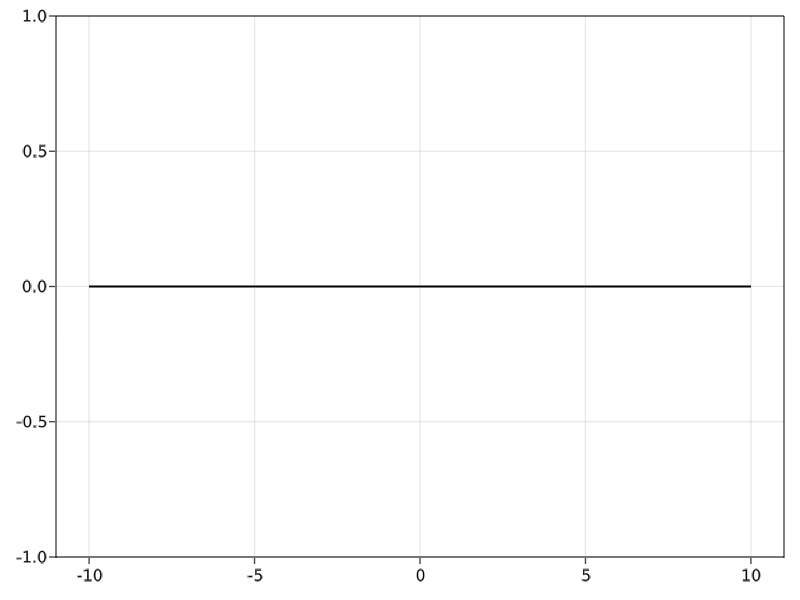

In [6]:
fig, ax = plot(Ω)
#scatter!(Ω, marker=:star8, markersize=4, color=:blue)
wireframe!(Ω, color=:black, linewidth=2)
fig


In [15]:
#Γ = BoundaryTriangulation(model,tags=boundary_tags)
#dΓ = Measure(Γ,degree)
#fig, ax = plot(Γ, linewidth=8)
#ax.aspect = AxisAspect(1)
#wireframe!(Γ, color=:black, linewidth=1)
#fig

In [7]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)

V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
U = TrialFESpace(V,dirichlet_values)


TrialFESpace()

In [8]:
#cambiamos el signo de p con respecto a la definición anterior
if test_1
    p(x) = 1
    q(x) = 0
    r(x) = 1
elseif test_2
    p(x) = x[1]
    q(x) = 0
    r(x) = 1/x[1]
elseif test_3
    p(x) = 1
    q(x) = x[1]*x[1]
    r(x) = 1
else
    p(x) = (1 + x[1] + 0.5*x[1]*x[1])/(10 + 0.5*x[1]*x[1]) # don't remember this potential...
    q(x) = -10*x[1]/(1 + 5*x[1]*x[1])
    r(x) = 1
end


r (generic function with 1 method)

Graficamos las funciones de la ec dif

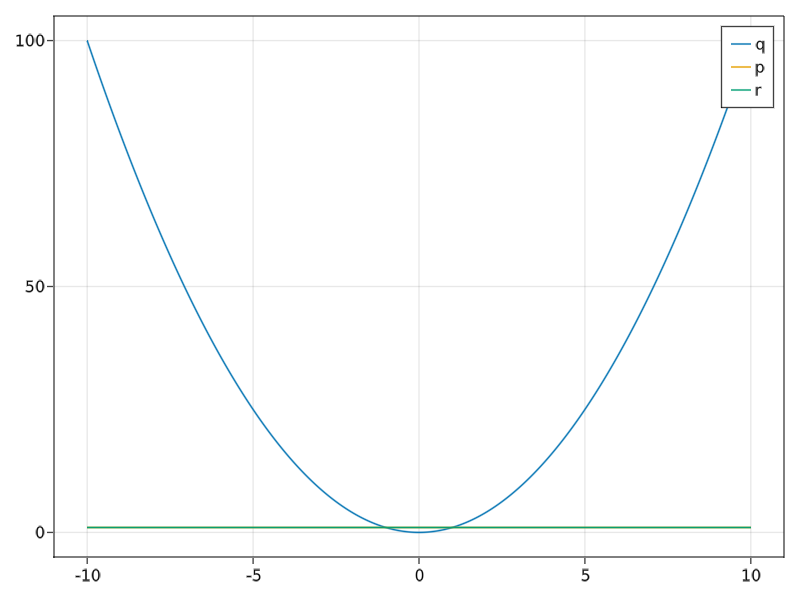

In [9]:
x = range(par[1], par[2], length=4000)
yq = q.(x)
yp = p.(x)
yr = r.(x)
lines(x, yq, label= "q")
lines!(x, yp, label= "p")
lines!(x, yr, label= "r")
axislegend()
current_figure()


Definimos el problema variacional

In [10]:
a(u,v) = ∫(p*∇(v)⋅∇(u) + q*v*u)*dΩ
m(u,v) = ∫(r*u*v)dΩ


m (generic function with 1 method)

Inlcuimos el note de resolución

In [12]:
include("eigen.jl")


solve (generic function with 1 method)

Resolvemos

In [13]:
nev = 5 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev=nev, tol=10^(-10), maxiter=100, explicittransform=:none, sigma=-1.0)
#prob = EigenProblem(a, m, U, V; nev=nev, which=:LM, explicittransform=:auto, tol=10^(-6), maxiter=100, sigma=0)
ξ, uₕs = solve(prob);


Ilustraremos los resultados y los compararemos con los exactos

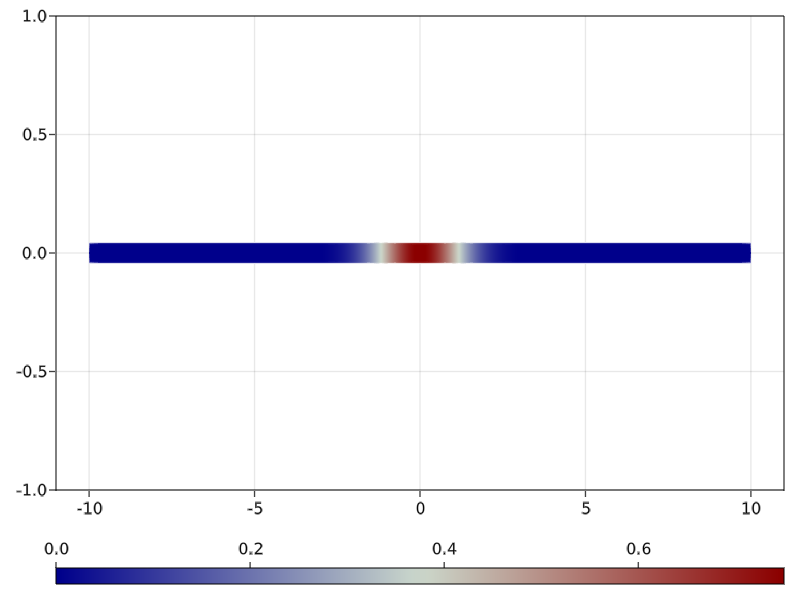

In [14]:
uₕ = uₕs[1]
fig, ax, plt = plot(Ω, real(uₕ), linewidth=20)
#ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

In [15]:
u=(uₕs[1],uₕs[2], uₕs[3],uₕs[4],uₕs[5])

(SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction())

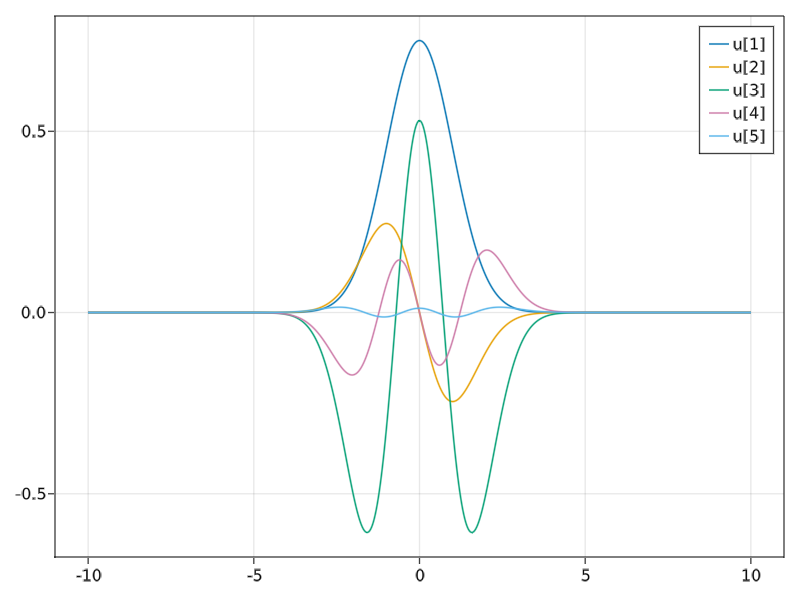

In [16]:

x = range(par[1], par[2], length=4000)
lines(x, evaluate(real(u[1]),Gridap.Point.(x)), label= "u[1]")
lines!(x, evaluate(real(u[2]),Gridap.Point.(x)), label= "u[2]")
lines!(x, evaluate(real(u[3]),Gridap.Point.(x)), label= "u[3]")
lines!(x, evaluate(real(u[4]),Gridap.Point.(x)), label= "u[4]")
lines!(x, evaluate(real(u[5]),Gridap.Point.(x)), label= "u[5]")
axislegend()
current_figure() 


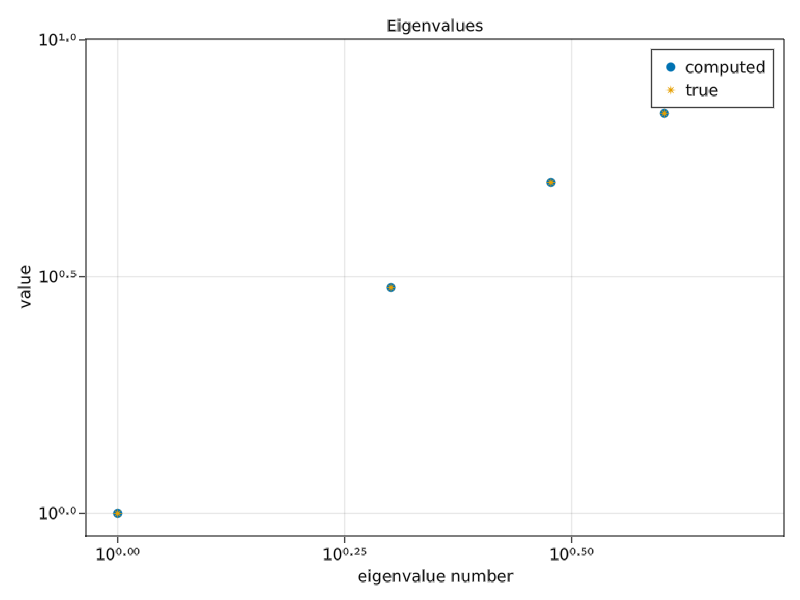

In [17]:
fig = Figure()

ax = Axis(fig[1, 1], xlabel = "eigenvalue number", ylabel = "value",
    title = "Eigenvalues", yscale = log10, xscale = log10)

scatter!(sort(real(ξ[1:nev])), label = "computed")

if test_1
    scatter!(ax,[n^2 for n ∈ 1:nev], marker=:star8, label = "true")
elseif test_2
    scatter!([(n*π/log(L))^2 for n ∈ 1:nev], marker=:star8, label = "true")
elseif test_3
    scatter!([1 + 2*(n-1) for n ∈ 1:nev], marker=:star8, label = "true")
end
axislegend()
current_figure()
fig

In [18]:
ξ

5-element Vector{ComplexF64}:
  1.000000000007685 - 3.159228003539195e-16im
 3.0000000000264873 - 1.6668621586197889e-15im
  5.000000000086282 - 3.165867113701447e-16im
  7.000000000210639 + 1.6240576342424407e-15im
  9.000000000426953 + 1.2563913164340088e-15im

And here we can save them into a file to see it with visit, for instance. 

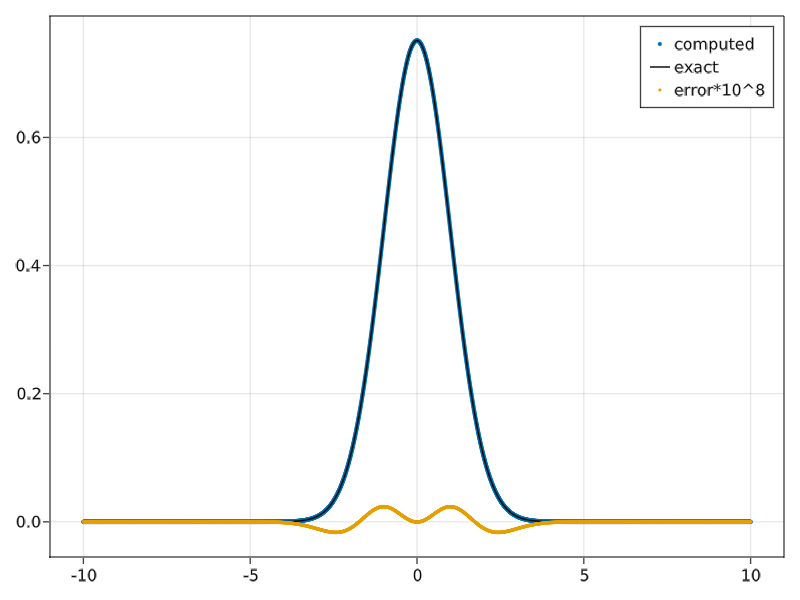

In [25]:
n=1 # for test_3 use n=4

uₕ = u[n]
# normalize the eigenvalue
u2 = sum(∫(uₕ*uₕ)*dΩ)
uₕ = uₕ/sqrt(u2)

if test_1
    u_n(x) = -sin(n*x)/sqrt(π/2)
elseif test_2
    freq=n*π/log(L)
    u_n(x) = sqrt((4*freq^2+1)/(2(L-1)*freq^2))*sin(freq*log(x))
elseif test_3
    u_n(x) = exp(-x^2/2)/sqrt(sqrt(π))
end

x = range(par[1], par[2], length=4000)
scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "computed",markersize = 4)
lines!(x, u_n.(x), label= "exact", color = :black)
scatter!(x, (evaluate(real(uₕ),Gridap.Point.(x))-u_n.(x))*100000000, label= "error*10^8", markersize = 3)
axislegend()
current_figure()        

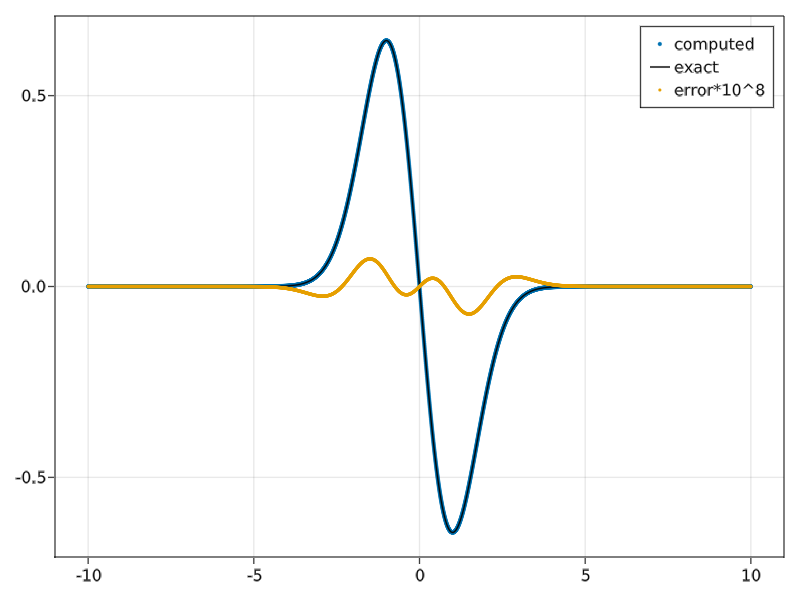

In [26]:
n=2 # for test_3 use n=4

uₕ = u[n]
# normalize the eigenvalue
u2 = sum(∫(uₕ*uₕ)*dΩ)
uₕ = uₕ/sqrt(u2)

if test_1
    u_n(x) = -sin(n*x)/sqrt(π/2)
elseif test_2
    freq=n*π/log(L)
    u_n(x) = sqrt((4*freq^2+1)/(2(L-1)*freq^2))*sin(freq*log(x))
elseif test_3
    u_n(x) = (-exp(-x^2/2)*2*x)/sqrt(4. * (sqrt(π)/2 - 10. /exp(100)))
end

x = range(par[1], par[2], length=4000)
scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "computed",markersize = 4)
lines!(x, u_n.(x), label= "exact", color = :black)
scatter!(x, (evaluate(real(uₕ),Gridap.Point.(x))-u_n.(x))*100000000, label= "error*10^8", markersize = 3)
axislegend()
current_figure()    

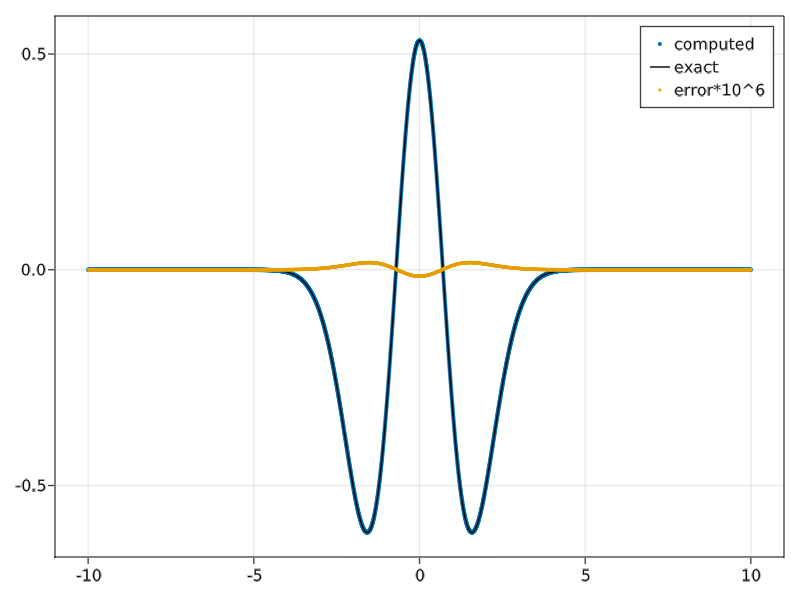

In [33]:
n=3 # for test_3 use n=4

uₕ = u[n]
# normalize the eigenvalue
u2 = sum(∫(uₕ*uₕ)*dΩ)
uₕ = uₕ/sqrt(u2)

if test_1
    u_n(x) = -sin(n*x)/sqrt(π/2)
elseif test_2
    freq=n*π/log(L)
    u_n(x) = sqrt((4*freq^2+1)/(2(L-1)*freq^2))*sin(freq*log(x))
elseif test_3
    u_n(x) = -(exp(-x^2/2)*(4*x^2-2.))/sqrt(14.17963)
end

x = range(par[1], par[2], length=4000)
scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "computed",markersize = 4)
lines!(x, u_n.(x), label= "exact", color = :black)
scatter!(x, (evaluate(real(uₕ),Gridap.Point.(x))-u_n.(x))*1000000, label= "error*10^6", markersize = 3)
axislegend()
current_figure() 

## Estudiemos la convergencia del método

In [19]:
i=[2,4]

2-element Vector{Int64}:
 2
 4

In [20]:
    grid_type = "1D"
    h = 1/(200*i[1])
    par = (-10,10, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    model = make_model(grid_type, par)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.00697374s, CPU 0.015625s)
Info    : 8001 nodes 8002 elements
Info    : Writing 'models/1D.msh'...
Info    : Done writing 'models/1D.msh'
Info    : Reading 'models/1D.msh'...
Info    : 3 entities
Info    : 8001 nodes
Info    : 8002 elements
Info    : Done reading 'models/1D.msh'


UnstructuredDiscreteModel()

In [21]:
    Ω = Triangulation(model)
    degree = 3
    dΩ = Measure(Ω,degree)

Measure()

In [22]:
    order = 2
    reffe = ReferenceFE(lagrangian,Float64,order)

(Lagrangian(), (Float64, 2), Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [23]:
    V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
    U = TrialFESpace(V,dirichlet_values)

TrialFESpace()

In [24]:
    p(x) = 1
    q(x) = x[1]*x[1]
    r(x) = 1

r (generic function with 1 method)

In [25]:
    a(u,v) = ∫(p*∇(v)⋅∇(u) + q*v*u)*dΩ
    m(u,v) = ∫(r*u*v)dΩ

m (generic function with 1 method)

In [26]:
include("eigen.jl")

solve (generic function with 1 method)

In [ ]:
    nev = 5 # number of eigenvalues asked to evaluate.
    prob = EigenProblem(a, m, U, V; nev=nev, tol=10^(-10), maxiter=100, explicittransform=:none, sigma=-1.0)
    ξ, uₕs = solve(prob);


In [ ]:
    u1=(uₕs[1],uₕs[2], uₕs[3],uₕs[4],uₕs[5])

In [24]:
h

0.0025

In [23]:
uₕs[1]

SingleFieldFEFunction():
 num_cells: 4000
 DomainStyle: ReferenceDomain()
 Triangulation: UnstructuredGrid()
 Triangulation id: 1372777941649573214

In [116]:
    grid_type = "1D"
    h = 1/200*i[2]
    par = (-10,10, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
    Ω = Triangulation(model)
    degree = 3
    dΩ = Measure(Ω,degree)

    order = 2
    reffe = ReferenceFE(lagrangian,Float64,order)

    V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
    U = TrialFESpace(V,dirichlet_values)
    
    p(x) = 1
    q(x) = x[1]*x[1]
    r(x) = 1

    x = range(par[1], par[2], length=1000)
    yq = q.(x)
    yp = p.(x)
    yr = r.(x)
    
    a(u,v) = ∫(p*∇(v)⋅∇(u) + q*v*u)*dΩ
    m(u,v) = ∫(r*u*v)dΩ

    nev = 5 # number of eigenvalues asked to evaluate.
    prob = EigenProblem(a, m, U, V; nev=nev, tol=10^(-10), maxiter=100, explicittransform=:none, sigma=-1.0)
    ξ, uₕs = solve(prob);


    u2=(uₕs[1],uₕs[2], uₕs[3],uₕs[4],uₕs[5])


(SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction())

In [148]:
x = range(par[1], par[2], length=4000)

-10.0:0.005001250312578144:10.0

In [114]:
u1_exacta(x) = exp(-x^2/2)/sqrt(sqrt(π))
u2_exacta(x) = (-exp(-x^2/2)*2*x)/sqrt(4. * (sqrt(π)/2 - 10. /exp(100)))
u3_exacta(x) = (exp(-x^2/2)*(4*x^2-2.))/sqrt(14.17963)


u3_exacta (generic function with 1 method)

In [144]:
u_exacta=[u1_exacta,u2_exacta,u3_exacta]

3-element Vector{Function}:
 u1_exacta (generic function with 1 method)
 u2_exacta (generic function with 1 method)
 u3_exacta (generic function with 1 method)

In [134]:
Q11=sqrt.((u1_exacta.(x)-evaluate(real(u[1]),Gridap.Point.(x))) .* (u1_exacta.(x)-evaluate(real(u[1]),Gridap.Point.(x))) ) ./ sqrt.( (evaluate(real(u[1]),Gridap.Point.(x)) - evaluate(real(u1[1]),Gridap.Point.(x)) )   .* (evaluate(real(u[1]),Gridap.Point.(x)) - evaluate(real(u1[1]),Gridap.Point.(x)) ))

1000-element Vector{Float64}:
 Inf
  4.055693228377003
  0.9254973790146871
  0.7086092938493848
  0.7640326609756745
  0.8056851629176387
  0.8397382608762237
  0.6672864431670377
  0.47214488812086286
  1.1080513335677329
  1.2652371152883195
  1.095008909070904
  1.1524810782607953
  ⋮
  1.0716736061693783
  0.5044080192692995
  0.4234904556694062
  0.7207592427708965
  0.7411968661064293
  0.6284027922259575
  0.6118977256877753
  0.7917690455543809
  0.5259219793528667
  0.6616932729640747
  0.5751259238919831
 Inf

In [138]:
Q12=sqrt.((evaluate(real(u[1]),Gridap.Point.(x)) - evaluate(real(u1[1]),Gridap.Point.(x))) .* (evaluate(real(u[1]),Gridap.Point.(x)) - evaluate(real(u1[1]),Gridap.Point.(x))) ) ./ sqrt.( (evaluate(real(u1[1]),Gridap.Point.(x)) - evaluate(real(u2[1]),Gridap.Point.(x))) .* (evaluate(real(u1[1]),Gridap.Point.(x)) - evaluate(real(u2[1]),Gridap.Point.(x))))

1000-element Vector{Float64}:
 NaN
   2.2857764652248513
   1.0972626429362549
   2.0785564878645686
   2.1303565620975657
   1.782081952161613
   2.6103140007462766
   1.4333734418364232
   0.9006209414905052
   0.7176625127522984
   1.0868822043175566
   2.027074610591258
   1.8226299764140166
   ⋮
   0.34938416510952935
   2.085512831256499
   6.7256784781234975
   1.3691197627744174
   3.699583007247096
   7.33531374656498
   6.674106603516633
  21.654182079300604
   2.090774939169078
   1.9938689261768
   2.199180801207966
 NaN

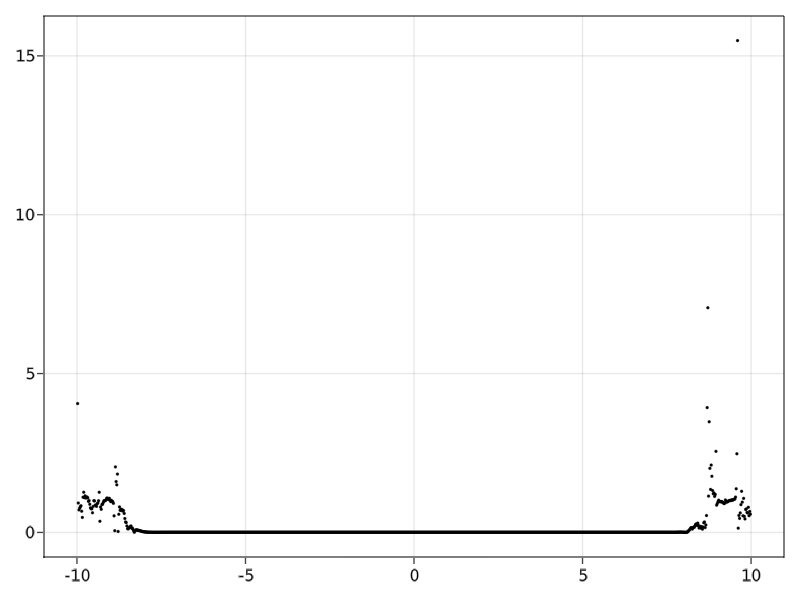

In [135]:
plot(x,Q11, markersize = 3)

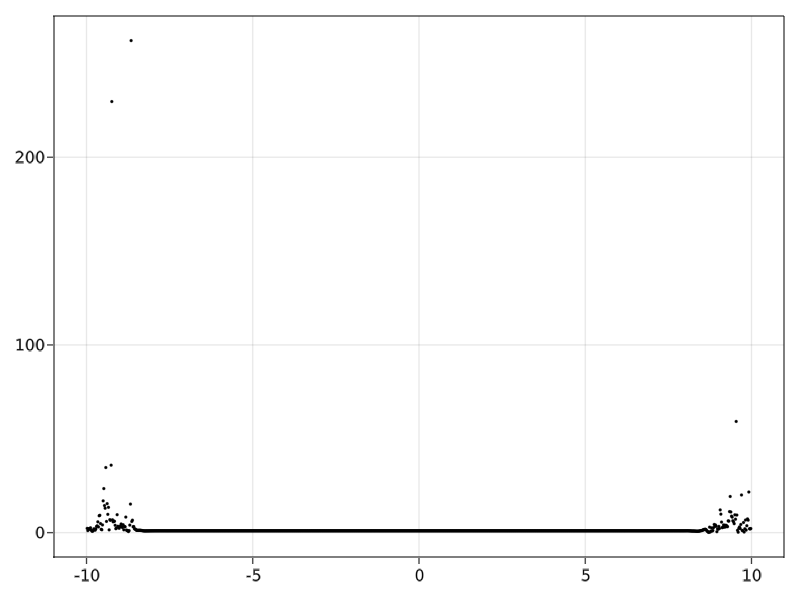

In [139]:
plot(x,Q12, markersize = 3)

In [140]:
Q21=sqrt.((u2_exacta.(x)-evaluate(real(u[2]),Gridap.Point.(x))) .* (u2_exacta.(x)-evaluate(real(u[2]),Gridap.Point.(x))) ) ./ sqrt.( (evaluate(real(u[2]),Gridap.Point.(x)) - evaluate(real(u1[2]),Gridap.Point.(x)) )   .* (evaluate(real(u[2]),Gridap.Point.(x)) - evaluate(real(u1[2]),Gridap.Point.(x)) ))

1000-element Vector{Float64}:
 Inf
  1.0421499430565286
  1.0453011206790084
  0.7768381222182903
  0.7236394328970864
  0.9834554335811175
  0.8207602600884385
  0.7756939609376505
  0.5802583167268162
  2.914070019335296
  1.166404240020672
  1.170837533953625
  1.1725780528498944
  ⋮
  0.7553009104981465
  0.7008166616350453
  0.5915227719090095
  0.6133924402288731
  0.7676606997195118
  0.9048916330051344
  0.8019798148622799
  0.9471799324428604
  1.0300976134991473
  0.6063539641621787
  0.6762827717301314
 Inf

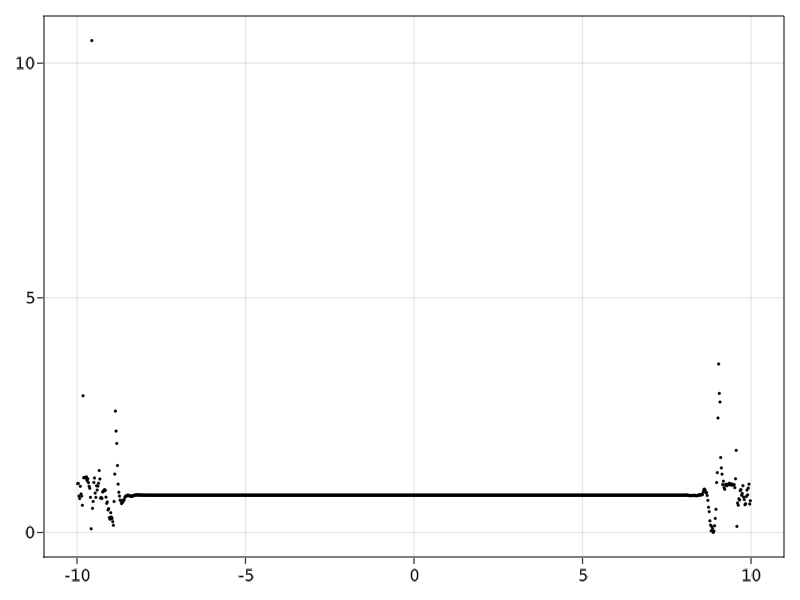

In [141]:
plot(x,Q21, markersize = 3)

In [145]:
evaluate(real(u),Gridap.Point.(x))

LoadError: MethodError: no method matching real(::NTuple{5, Gridap.FESpaces.SingleFieldFEFunction{Gridap.CellData.GenericCellField{ReferenceDomain}}})
[0mClosest candidates are:
[0m  real([91m::Tridiagonal[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\LinearAlgebra\src\tridiag.jl:598
[0m  real([91m::ColorTypes.AbstractGray{T} where T[39m) at C:\Users\LENOVO\.julia\packages\ColorTypes\6m8P7\src\conversions.jl:117
[0m  real([91m::UpperHessenberg{var"#s832", S} where {var"#s832"<:Real, S<:AbstractMatrix{var"#s832"}}[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\LinearAlgebra\src\hessenberg.jl:64
[0m  ...

In [ ]:
Q=norm(evaluate(real(u),Gridap.Point.(x))- sol_2(t)[:,:],5)/norm(sol_2(t)[:,:]-sol_4(t)[:,:],2)